# Analisis completo de imagen de calcio

Este notebook reproduce el flujo de analisis de la app: carga de datos, preprocesamiento, deteccion de eventos, calculo de metricas y analisis espectral. Cada seccion explica la teoria y el por que de cada paso.

## Indice

1. Configuracion e imports
2. Carga de datos
3. Preprocesamiento: suavizado SG y filtrado Butterworth
4. Deteccion robusta de eventos (rolling MAD)
5. Metricas por estimulo
6. Analisis espectral (FFT y Welch)
7. Guia de seleccion de parametros

## 1. Configuracion e imports

Se importan librerias de analisis numerico, señales y graficos. Se usan funciones de SciPy para filtros digitales y para espectros.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.integrate import trapezoid

### Parametros base

- `sg_window`, `sg_poly`: suavizado con Savitzky-Golay. Se usa para reducir ruido de alta frecuencia conservando la forma de picos.
- `butter_type`, `butter_order`, `butter_cutoff`: filtro Butterworth. Su respuesta suave evita oscilaciones de borde y mantiene transitorios si el corte es razonable.
- `signal_window`, `k_up`, `k_down`: parametros de deteccion robusta con baseline movil.

Estos valores son iniciales y se ajustan segun el muestreo y la duracion total.

In [2]:
sg_window = 15
sg_poly = 3
butter_type = 'lowpass'
butter_order = 4
butter_cutoff = 0.05  # Hz
signal_window = 20
k_up = 1.65
k_down = 1.65

## 2. Carga de datos

Se asume la misma estructura que la app: una carpeta `Experimentos/` con subcarpetas. Cada subcarpeta incluye un `.txt` con señales y un `.csv` con estimulos.

In [3]:
base_dir = os.path.join('..', 'Experimentos')
carpetas = [c for c in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, c))]
print('Carpetas:', carpetas)
exper = 0  # indice de carpeta
archivos = os.listdir(os.path.join(base_dir, carpetas[exper]))
txt_files = [a for a in archivos if a.endswith('.txt')]
csv_files = [a for a in archivos if a.endswith('.csv')]
txt_path = os.path.join(base_dir, carpetas[exper], txt_files[0])
csv_path = os.path.join(base_dir, carpetas[exper], csv_files[0])
data = pd.read_csv(txt_path, sep='	', skiprows=3, header=1)
data.columns = ['Time'] + [f'ROI_{i}' for i in range(1, len(data.columns))]
data.iloc[:, 0] = data.iloc[:, 0] / (1000 * 60)  # ms -> min
data_csv = pd.read_csv(csv_path, sep=';', decimal=',')
data_csv.iloc[:, 0] = data_csv.iloc[:, 0].str.upper()
data.head()

Carpetas: ['ID002_A_002']


,Time,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ROI_8,ROI_9,ROI_10
0,0.000000,0.2439,0.1969,0.2452,0.1923,0.1283,0.2342,0.1851,0.1136,0.1492,0.2235
1,0.084925,0.2486,0.1922,0.2390,0.1964,0.1328,0.2389,0.1826,0.1229,0.1641,0.2203
2,0.169850,0.2461,0.1921,0.2401,0.1953,0.1308,0.2368,0.1817,0.1173,0.1641,0.2187
3,0.254775,0.2469,0.1954,0.2461,0.1969,0.1302,0.2358,0.1839,0.1176,0.1618,0.2188
4,0.339700,0.2407,0.1935,0.2460,0.1912,0.1266,0.2337,0.1855,0.1134,0.1539,0.2169


## 3. Preprocesamiento

### 3.1 Suavizado Savitzky-Golay

**Por que suavizar:** la senal tiene ruido instrumental y fluctuaciones no biologicas. Un filtro SG ajusta polinomios locales, conserva pendientes y picos mejor que una media movil.

### 3.2 Filtro Butterworth

**Que es:** filtro digital con respuesta suave. En modo paso bajo elimina oscilaciones rapidas sin distorsionar demasiado el transitorio.

**Eleccion de cortes:** el corte debe estar por encima de la frecuencia de interes biologico y por debajo del ruido.

In [4]:
def estimate_sampling_rate(time_min):
    if len(time_min) < 2:
        return 0.0
    dt_min = np.nanmedian(np.diff(time_min))
    if dt_min <= 0:
        return 0.0
    return 1.0 / (dt_min * 60.0)

def savgol_smooth(x, window, polyorder):
    if window % 2 == 0:
        window += 1
    return signal.savgol_filter(x, window_length=window, polyorder=polyorder)

def butter_filter(x, sampling_rate_hz, ftype, cutoff_hz, order=4):
    if sampling_rate_hz <= 0:
        return x.copy()
    nyquist = 0.5 * sampling_rate_hz
    if isinstance(cutoff_hz, (tuple, list)):
        low, high = cutoff_hz
        if low <= 0 or high >= nyquist or low >= high:
            return x.copy()
        wn = [low / nyquist, high / nyquist]
    else:
        if cutoff_hz <= 0 or cutoff_hz >= nyquist:
            return x.copy()
        wn = cutoff_hz / nyquist
    b, a = signal.butter(order, wn, btype=ftype, analog=False)
    return signal.filtfilt(b, a, x)

t = data['Time'].to_numpy()
fs = estimate_sampling_rate(t)
data_sg = data.copy()
data_bw = data.copy()
for col in data.columns[1:]:
    x = data[col].to_numpy()
    data_sg[col] = savgol_smooth(x, sg_window, sg_poly)
    data_bw[col] = butter_filter(x, fs, butter_type, butter_cutoff, order=butter_order)

print('fs:', fs)
data_sg.head()

fs: 0.19625159454420535


,Time,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ROI_8,ROI_9,ROI_10
0,0.000000,0.246011,0.196021,0.241274,0.194463,0.130353,0.235663,0.183623,0.117437,0.154696,0.222322
1,0.084925,0.246224,0.193634,0.243228,0.194593,0.130259,0.236383,0.183751,0.117262,0.157798,0.220822
2,0.169850,0.245797,0.192631,0.244144,0.194570,0.129942,0.236570,0.183748,0.117035,0.159802,0.219734
3,0.254775,0.244850,0.192746,0.244160,0.194419,0.129445,0.236307,0.183625,0.116764,0.160872,0.218981
4,0.339700,0.243501,0.193716,0.243415,0.194163,0.128811,0.235674,0.183392,0.116456,0.161176,0.218487


### Visualizacion SG vs Butterworth

Se compara la señal original con cada filtrado.

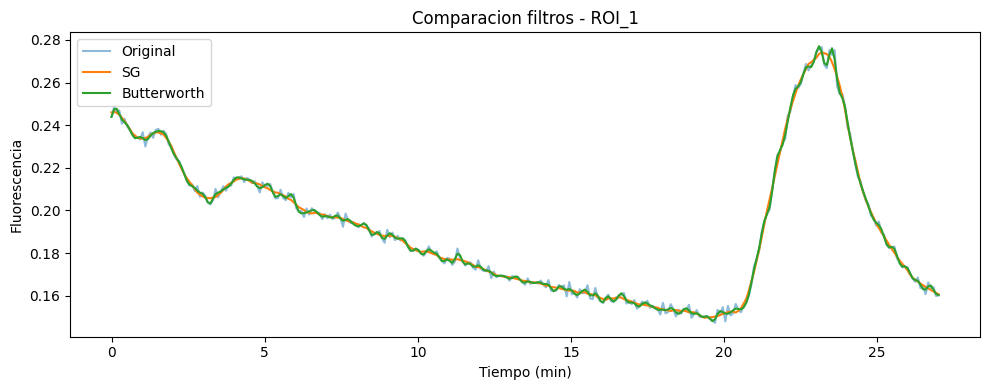

In [5]:
roi = data.columns[1]
plt.figure(figsize=(10, 4))
plt.plot(t, data[roi], label='Original', alpha=0.5)
plt.plot(t, data_sg[roi], label='SG', linewidth=1.5)
plt.plot(t, data_bw[roi], label='Butterworth', linewidth=1.5)
plt.legend()
plt.xlabel('Tiempo (min)')
plt.ylabel('Fluorescencia')
plt.title(f'Comparacion filtros - {roi}')
plt.tight_layout()
plt.show()

## 4. Deteccion robusta de eventos (rolling MAD)

**Por que MAD:** el MAD es robusto a valores atipicos. En senales con picos, usar desviacion estandar puede inflar el umbral.

**Rolling MAD:** calcula el MAD en una ventana local para adaptarse a cambios de baseline.

A continuacion se implementa una deteccion con histéresis (k_up, k_down) similar a la app.

In [6]:
def rolling_mad_sigma(x, w):
    s = pd.Series(x)
    med = s.rolling(w, center=True, min_periods=max(5, w // 3)).median()
    mad = (s - med).abs().rolling(w, center=True, min_periods=max(5, w // 3)).median()
    sigma = (mad / 0.6745).to_numpy(copy=True)
    sigma[np.isnan(sigma)] = np.nanmedian(sigma)
    return np.maximum(sigma, 1e-12)

def robust_event_detection(x, w=20, k_up=1.65, k_down=1.65, influence=0.95, run_min=10):
    n = len(x)
    mask = np.zeros(n)
    x_filt = x[:w].copy()
    baseline = np.nanmedian(x_filt)
    std_dev = np.nanmedian(np.abs(x_filt - baseline)) / 0.6745
    baseline_arr = np.zeros(n)
    std_arr = np.zeros(n)
    baseline_arr[:w] = baseline
    std_arr[:w] = std_dev
    for i in range(w, n):
        diff = x[i] - baseline
        if (diff > k_up * std_dev and diff > 0) or (diff > 0 and mask[i - 1] == 1):
            mask[i] = 1
            x_filt = np.append(x_filt, influence * x[i] + (1 - influence) * x_filt[-1])
        elif (diff < -k_down * std_dev and diff < 0) or (diff < 0 and mask[i - 1] == -1):
            mask[i] = -1
            x_filt = np.append(x_filt, influence * x[i] + (1 - influence) * x_filt[-1])
        else:
            mask[i] = 0
            x_filt = np.append(x_filt, x[i])
        if i > w + run_min:
            if mask[i] == 1 and np.sum(mask[i-run_min:i-1] == 1) > 0.8 * run_min:
                mask[i-run_min:i] = 1
            elif mask[i] == -1 and np.sum(mask[i-run_min:i-1] == -1) > 0.8 * run_min:
                mask[i-run_min:i] = -1
        x_filt = x_filt[-w:]
        baseline = np.nanmedian(x_filt)
        mad = np.nanmedian(np.abs(x_filt - baseline))
        std_dev = 1.4826 * mad
        baseline_arr[i] = baseline
        std_arr[i] = std_dev
    return mask, baseline_arr, std_arr

### Ejemplo de deteccion con señal filtrada

Puedes elegir `x_sg` o `x_bw` segun el analisis.

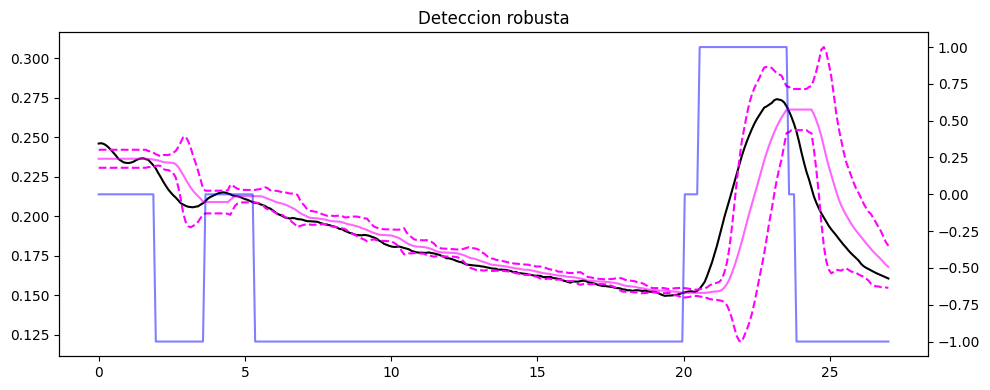

In [7]:
x_sg = data_sg[roi].to_numpy()
mask, baseline, std = robust_event_detection(x_sg, w=signal_window, k_up=k_up, k_down=k_down)
plt.figure(figsize=(10, 4))
plt.plot(t, x_sg, color='black', label='SG')
plt.plot(t, baseline, color='magenta', alpha=0.6, label='Baseline')
plt.plot(t, baseline + k_up * std, color='magenta', linestyle='--')
plt.plot(t, baseline - k_down * std, color='magenta', linestyle='--')
plt.twinx()
plt.plot(t, mask, color='blue', alpha=0.5, label='Eventos')
plt.title('Deteccion robusta')
plt.tight_layout()
plt.show()

## 5. Metricas por estimulo

Se calcula el area bajo la curva, duracion y maximo entre el inicio del estimulo y el ultimo evento de bajada antes del siguiente estimulo.

Esto emula el comportamiento de la app: selecciona el primer evento de subida tras el inicio del estimulo, y el ultimo evento de bajada posterior.

In [8]:
def calculate_metrics(signal_data, time_array, event_mask, stim_start, stim_end, next_start=None):
    effective_end = next_start if next_start is not None else time_array[-1]
    start_indices = np.where((time_array >= stim_start) & (time_array <= effective_end) & (event_mask == 1))[0]
    if len(start_indices) == 0:
,


,

IndentationError: expected an indented block after 'if' statement on line 4 (671403269.py, line 5)